<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Lists" data-toc-modified-id="Lists-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Lists</a></span></li><li><span><a href="#Formatting-functions" data-toc-modified-id="Formatting-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Formatting functions</a></span></li><li><span><a href="#API-call-functions" data-toc-modified-id="API-call-functions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>API call functions</a></span></li></ul></li><li><span><a href="#Data-aquisition" data-toc-modified-id="Data-aquisition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data aquisition</a></span><ul class="toc-item"><li><span><a href="#Fetch-online-data" data-toc-modified-id="Fetch-online-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fetch online data</a></span></li><li><span><a href="#Format-data" data-toc-modified-id="Format-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Format data</a></span></li><li><span><a href="#Save-data" data-toc-modified-id="Save-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Save data</a></span></li></ul></li><li><span><a href="#Check-changes" data-toc-modified-id="Check-changes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check changes</a></span><ul class="toc-item"><li><span><a href="#Load-latest-file" data-toc-modified-id="Load-latest-file-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load latest file</a></span></li><li><span><a href="#Generate-changelog" data-toc-modified-id="Generate-changelog-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate changelog</a></span></li></ul></li><li><span><a href="#Data-visualisation" data-toc-modified-id="Data-visualisation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data visualisation</a></span><ul class="toc-item"><li><span><a href="#Full-data" data-toc-modified-id="Full-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Full data</a></span></li><li><span><a href="#Card-types" data-toc-modified-id="Card-types-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Card types</a></span></li><li><span><a href="#Monsters" data-toc-modified-id="Monsters-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Monsters</a></span><ul class="toc-item"><li><span><a href="#Attributes" data-toc-modified-id="Attributes-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Attributes</a></span></li><li><span><a href="#Primary-types" data-toc-modified-id="Primary-types-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Primary types</a></span><ul class="toc-item"><li><span><a href="#Has-effect-discrimination" data-toc-modified-id="Has-effect-discrimination-4.3.2.1"><span class="toc-item-num">4.3.2.1&nbsp;&nbsp;</span>Has effect discrimination</a></span></li><li><span><a href="#Is-pendulum-discrimination" data-toc-modified-id="Is-pendulum-discrimination-4.3.2.2"><span class="toc-item-num">4.3.2.2&nbsp;&nbsp;</span>Is pendulum discrimination</a></span></li><li><span><a href="#By-attribute" data-toc-modified-id="By-attribute-4.3.2.3"><span class="toc-item-num">4.3.2.3&nbsp;&nbsp;</span>By attribute</a></span></li></ul></li><li><span><a href="#Secondary-types" data-toc-modified-id="Secondary-types-4.3.3"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>Secondary types</a></span><ul class="toc-item"><li><span><a href="#By-attribute" data-toc-modified-id="By-attribute-4.3.3.1"><span class="toc-item-num">4.3.3.1&nbsp;&nbsp;</span>By attribute</a></span></li><li><span><a href="#By-secondary-type" data-toc-modified-id="By-secondary-type-4.3.3.2"><span class="toc-item-num">4.3.3.2&nbsp;&nbsp;</span>By secondary type</a></span></li></ul></li><li><span><a href="#Monster-types" data-toc-modified-id="Monster-types-4.3.4"><span class="toc-item-num">4.3.4&nbsp;&nbsp;</span>Monster types</a></span><ul class="toc-item"><li><span><a href="#By-Attribute" data-toc-modified-id="By-Attribute-4.3.4.1"><span class="toc-item-num">4.3.4.1&nbsp;&nbsp;</span>By Attribute</a></span></li><li><span><a href="#By-primary-type" data-toc-modified-id="By-primary-type-4.3.4.2"><span class="toc-item-num">4.3.4.2&nbsp;&nbsp;</span>By primary type</a></span></li><li><span><a href="#By-secondary-type" data-toc-modified-id="By-secondary-type-4.3.4.3"><span class="toc-item-num">4.3.4.3&nbsp;&nbsp;</span>By secondary type</a></span></li></ul></li><li><span><a href="#Effect-type" data-toc-modified-id="Effect-type-4.3.5"><span class="toc-item-num">4.3.5&nbsp;&nbsp;</span>Effect type</a></span></li><li><span><a href="#ATK" data-toc-modified-id="ATK-4.3.6"><span class="toc-item-num">4.3.6&nbsp;&nbsp;</span>ATK</a></span></li><li><span><a href="#DEF" data-toc-modified-id="DEF-4.3.7"><span class="toc-item-num">4.3.7&nbsp;&nbsp;</span>DEF</a></span></li><li><span><a href="#Level/Rank" data-toc-modified-id="Level/Rank-4.3.8"><span class="toc-item-num">4.3.8&nbsp;&nbsp;</span>Level/Rank</a></span><ul class="toc-item"><li><span><a href="#ATK-statistics" data-toc-modified-id="ATK-statistics-4.3.8.1"><span class="toc-item-num">4.3.8.1&nbsp;&nbsp;</span>ATK statistics</a></span></li><li><span><a href="#DEF-statistics" data-toc-modified-id="DEF-statistics-4.3.8.2"><span class="toc-item-num">4.3.8.2&nbsp;&nbsp;</span>DEF statistics</a></span></li></ul></li><li><span><a href="#Pendulum-scale" data-toc-modified-id="Pendulum-scale-4.3.9"><span class="toc-item-num">4.3.9&nbsp;&nbsp;</span>Pendulum scale</a></span><ul class="toc-item"><li><span><a href="#ATK-statistics" data-toc-modified-id="ATK-statistics-4.3.9.1"><span class="toc-item-num">4.3.9.1&nbsp;&nbsp;</span>ATK statistics</a></span></li><li><span><a href="#DEF-statistics" data-toc-modified-id="DEF-statistics-4.3.9.2"><span class="toc-item-num">4.3.9.2&nbsp;&nbsp;</span>DEF statistics</a></span></li><li><span><a href="#Level/Rank-statistics" data-toc-modified-id="Level/Rank-statistics-4.3.9.3"><span class="toc-item-num">4.3.9.3&nbsp;&nbsp;</span>Level/Rank statistics</a></span></li></ul></li><li><span><a href="#Link" data-toc-modified-id="Link-4.3.10"><span class="toc-item-num">4.3.10&nbsp;&nbsp;</span>Link</a></span><ul class="toc-item"><li><span><a href="#ATK-statistics" data-toc-modified-id="ATK-statistics-4.3.10.1"><span class="toc-item-num">4.3.10.1&nbsp;&nbsp;</span>ATK statistics</a></span></li></ul></li><li><span><a href="#Link-Arrows" data-toc-modified-id="Link-Arrows-4.3.11"><span class="toc-item-num">4.3.11&nbsp;&nbsp;</span>Link Arrows</a></span><ul class="toc-item"><li><span><a href="#By-combination" data-toc-modified-id="By-combination-4.3.11.1"><span class="toc-item-num">4.3.11.1&nbsp;&nbsp;</span>By combination</a></span></li><li><span><a href="#By-unique" data-toc-modified-id="By-unique-4.3.11.2"><span class="toc-item-num">4.3.11.2&nbsp;&nbsp;</span>By unique</a></span></li><li><span><a href="#By-link" data-toc-modified-id="By-link-4.3.11.3"><span class="toc-item-num">4.3.11.3&nbsp;&nbsp;</span>By link</a></span></li></ul></li></ul></li><li><span><a href="#Spell-&amp;-Trap" data-toc-modified-id="Spell-&amp;-Trap-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Spell &amp; Trap</a></span><ul class="toc-item"><li><span><a href="#Properties" data-toc-modified-id="Properties-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Properties</a></span></li><li><span><a href="#Effect-type" data-toc-modified-id="Effect-type-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Effect type</a></span><ul class="toc-item"><li><span><a href="#Spell-&amp;-Trap-discrimination" data-toc-modified-id="Spell-&amp;-Trap-discrimination-4.4.2.1"><span class="toc-item-num">4.4.2.1&nbsp;&nbsp;</span>Spell &amp; Trap discrimination</a></span></li></ul></li></ul></li><li><span><a href="#Archseries" data-toc-modified-id="Archseries-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Archseries</a></span><ul class="toc-item"><li><span><a href="#By-card-type" data-toc-modified-id="By-card-type-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>By card type</a></span></li><li><span><a href="#By-primary-type" data-toc-modified-id="By-primary-type-4.5.2"><span class="toc-item-num">4.5.2&nbsp;&nbsp;</span>By primary type</a></span></li><li><span><a href="#By-secondary-type" data-toc-modified-id="By-secondary-type-4.5.3"><span class="toc-item-num">4.5.3&nbsp;&nbsp;</span>By secondary type</a></span></li><li><span><a href="#By-monster-type" data-toc-modified-id="By-monster-type-4.5.4"><span class="toc-item-num">4.5.4&nbsp;&nbsp;</span>By monster type</a></span></li><li><span><a href="#By-property" data-toc-modified-id="By-property-4.5.5"><span class="toc-item-num">4.5.5&nbsp;&nbsp;</span>By property</a></span></li></ul></li><li><span><a href="#Artworks" data-toc-modified-id="Artworks-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Artworks</a></span><ul class="toc-item"><li><span><a href="#By-card-type" data-toc-modified-id="By-card-type-4.6.1"><span class="toc-item-num">4.6.1&nbsp;&nbsp;</span>By card type</a></span></li><li><span><a href="#By-primary-type" data-toc-modified-id="By-primary-type-4.6.2"><span class="toc-item-num">4.6.2&nbsp;&nbsp;</span>By primary type</a></span></li></ul></li><li><span><a href="#Errata" data-toc-modified-id="Errata-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Errata</a></span><ul class="toc-item"><li><span><a href="#By-card-type" data-toc-modified-id="By-card-type-4.7.1"><span class="toc-item-num">4.7.1&nbsp;&nbsp;</span>By card type</a></span></li><li><span><a href="#By-primary-type" data-toc-modified-id="By-primary-type-4.7.2"><span class="toc-item-num">4.7.2&nbsp;&nbsp;</span>By primary type</a></span></li><li><span><a href="#By-artwork" data-toc-modified-id="By-artwork-4.7.3"><span class="toc-item-num">4.7.3&nbsp;&nbsp;</span>By artwork</a></span></li></ul></li><li><span><a href="#TCG-&amp;-OCG-status" data-toc-modified-id="TCG-&amp;-OCG-status-4.8"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>TCG &amp; OCG status</a></span><ul class="toc-item"><li><span><a href="#TGC-status" data-toc-modified-id="TGC-status-4.8.1"><span class="toc-item-num">4.8.1&nbsp;&nbsp;</span>TGC status</a></span><ul class="toc-item"><li><span><a href="#By-card-type" data-toc-modified-id="By-card-type-4.8.1.1"><span class="toc-item-num">4.8.1.1&nbsp;&nbsp;</span>By card type</a></span></li><li><span><a href="#By-monster-type" data-toc-modified-id="By-monster-type-4.8.1.2"><span class="toc-item-num">4.8.1.2&nbsp;&nbsp;</span>By monster type</a></span></li><li><span><a href="#By-archseries" data-toc-modified-id="By-archseries-4.8.1.3"><span class="toc-item-num">4.8.1.3&nbsp;&nbsp;</span>By archseries</a></span></li></ul></li><li><span><a href="#OCG-status" data-toc-modified-id="OCG-status-4.8.2"><span class="toc-item-num">4.8.2&nbsp;&nbsp;</span>OCG status</a></span><ul class="toc-item"><li><span><a href="#By-card-type" data-toc-modified-id="By-card-type-4.8.2.1"><span class="toc-item-num">4.8.2.1&nbsp;&nbsp;</span>By card type</a></span></li><li><span><a href="#By-monster-type" data-toc-modified-id="By-monster-type-4.8.2.2"><span class="toc-item-num">4.8.2.2&nbsp;&nbsp;</span>By monster type</a></span></li><li><span><a href="#By-archseries" data-toc-modified-id="By-archseries-4.8.2.3"><span class="toc-item-num">4.8.2.3&nbsp;&nbsp;</span>By archseries</a></span></li></ul></li><li><span><a href="#TCG-vs.-OCG-status" data-toc-modified-id="TCG-vs.-OCG-status-4.8.3"><span class="toc-item-num">4.8.3&nbsp;&nbsp;</span>TCG vs. OCG status</a></span></li></ul></li></ul></li><li><span><a href="#HTML-export" data-toc-modified-id="HTML-export-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>HTML export</a></span></li><li><span><a href="#Searches" data-toc-modified-id="Searches-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Searches</a></span></li></ul></div>

# Preamble

## Imports

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib_venn import venn2
from datetime import datetime
from ast import literal_eval

## Lists

In [2]:
# Attributes to split monsters query
attributes = ['DIVINE', 'LIGHT', 'DARK', 'WATER', 'EARTH', 'FIRE', 'WIND']

# API variables
api_url = 'https://yugipedia.com/api.php'

# Styling dictionaries
arrows_dict = {'Middle-Left': '\u2190', 'Middle-Right': '\u2192', 'Top-Left': '\u2196', 'Top-Center': '\u2191', 'Top-Right': '\u2197', 'Bottom-Left': '\u2199', 'Bottom-Center': '\u2193', 'Bottom-Right': '\u2198'}
card_colors = {'Effect Monster': '#FF8B53', 'Normal Monster': '#FDE68A', 'Ritual Monster': '#9DB5CC', 'Fusion Monster': '#A086B7', 'Synchro Monster': '#CCCCCC', 'Xyz Monster': '#000000', 'Link Monster': '#00008B', 'Pendulum Monster': 'r', 'Monster Card': '#FF8B53', 'Spell Card': '#1D9E74', 'Trap Card': '#BC5A84', 'Monster Token': '#C0C0C0', 'FIRE': '#fd1b1b', 'WATER': '#03a9e6', 'EARTH': '#060d0a', 'WIND': '#77bb58', 'DARK': '#745ea5', 'LIGHT': '#9d8047', 'DIVINE': '#7e6537', 'Level': '#f1a41f'}

## Formatting functions

In [3]:
def extract_results(df):
    df = pd.DataFrame(df['query']['results']).transpose()
    df = pd.DataFrame(df['printouts'].values.tolist())
    return df

def extract_artwork(row):
    result = tuple()
    if 'Category:OCG/TCG cards with alternate artworks' in row:
        result += ('Alternate',)
    if 'Category:OCG/TCG cards with edited artworks' in row:
        result += ('Edited',)
    if result == tuple():
        return np.nan
    else:
        return result

def concat_errata(row):
    result = tuple()
    if row['Name errata']:
        result += ('Name',)
    if row['Type errata']:
        result += ('Type',)
    if result == tuple():
        return np.nan
    else:
        return result 
    
def format_df(input_df, input_errata_df):
    df = pd.DataFrame()
    if 'Name' in input_df.columns:
        df['Name'] = input_df['Name'].dropna().apply(lambda x: x[0])
    if 'Password' in input_df.columns:
        df['Password'] = input_df['Password'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Card type' in input_df.columns:
        df['Card type'] = input_df['Card type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Property' in input_df.columns:
        df['Property'] = input_df['Property'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Primary type' in input_df.columns:
        df['Primary type'] = input_df['Primary type'].dropna().apply(lambda x: [i['fulltext'] for i in x] if len(x)>0 else []).apply(lambda y: list(filter(lambda z: z != 'Pendulum Monster', y)) if len(y)>0 else []).apply(lambda y: list(filter(lambda z: z != 'Effect Monster', y))[0] if len(y)>1 else (y[0] if len(y)>0 else np.nan))
    if 'Secondary type' in input_df.columns:
        df['Secondary type'] = input_df['Secondary type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Attribute' in input_df.columns:
        df['Attribute'] = input_df['Attribute'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Monster type' in input_df.columns:
        df['Monster type'] = input_df['Monster type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Level/Rank' in input_df.columns:
        df['Level/Rank'] = input_df['Level/Rank'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'ATK' in input_df.columns:
        df['ATK'] = input_df['ATK'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'DEF' in input_df.columns:
        df['DEF'] = input_df['DEF'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Pendulum Scale' in input_df.columns:
        df['Pendulum Scale'] = input_df['Pendulum Scale'].dropna().apply(lambda x: str(x[0]) if len(x)>0 else np.nan)
    if 'Link' in input_df.columns:
        df['Link'] = input_df['Link'].dropna().apply(lambda x: str(x[0]) if len(x)>0 else np.nan)
    if 'Link Arrows' in input_df.columns:
        df['Link Arrows'] = input_df['Link Arrows'].dropna().apply(lambda x: tuple([arrows_dict[i] for i in sorted(x)]) if len(x)>0 else np.nan)
    if 'Effect type' in input_df.columns:
        df['Effect type'] = input_df['Effect type'].dropna().apply(lambda x: tuple(sorted([i['fulltext'] for i in x])) if len(x)>0 else np.nan)
    if 'Archseries' in input_df.columns:
        df['Archseries'] = input_df['Archseries'].dropna().apply(lambda x: tuple(sorted(x)) if len(x)>0 else np.nan)
    if 'Category' in input_df.columns:
        df['Artwork'] = input_df['Category'].dropna().apply(lambda x: [i['fulltext'] for i in x] if len(x)>0 else np.nan).apply(extract_artwork)
    # Erratas column
    if input_errata_df is not None and 'Page name' in input_df.columns:
        df['Errata'] = errata_df.merge(input_df['Page name'].dropna().apply(lambda x: x[0]).rename('Name'), right_on = 'Name', left_index = True).apply(concat_errata,axis = 1)
    #################
    if 'TCG status' in input_df.columns:
        df['TCG status'] = input_df['TCG status'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'OCG status' in input_df.columns:
        df['OCG status'] = input_df['OCG status'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Modification date' in input_df.columns:
        df['Modification date'] = input_df['Modification date'].dropna().apply(lambda x: pd.Timestamp(int(x[0]['timestamp']), unit='s').ctime() if len(x)>0 else np.nan)
    
    return df


## API call functions

In [4]:
def card_query(_password = True, _card_type = True, _property = True, _primary = True, _secondary = True, _attribute = True, _monster_type = True, _stars = True, _atk = True, _def = True, _scale = True, _link = True, _arrows = True, _effect_type = True, _archseries = True, _category = True, _tcg = True, _ocg = True, _date = True, _page_name = True):
    search_string = f'|?English%20name=Name'
    if _password:
        search_string += '|?Password'
    if _card_type:
        search_string += '|?Card%20type'
    if _property:    
        search_string += '|?Property'
    if _primary:
        search_string += '|?Primary%20type'
    if _secondary:
        search_string += '|?Secondary%20type'
    if _attribute:
        search_string += '|?Attribute'
    if _monster_type:
        search_string += '|?Type=Monster%20type'
    if _stars:
        search_string += '|?Stars%20string=Level%2FRank%20'
    if _atk:
        search_string += '|?ATK%20string=ATK'
    if _def:
        search_string += '|?DEF%20string=DEF'
    if _scale:
        search_string += '|?Pendulum%20Scale'
    if _link:
        search_string += '|?Link%20Rating=Link'
    if _arrows:
        search_string += '|?Link%20Arrows'
    if _effect_type:
        search_string += '|?Effect%20type'
    if _archseries:
        search_string += '|?Archseries'
    if _category:
        search_string += '|?category'
    if _tcg:
        search_string += '|?TCG%20status'
    if _ocg:
        search_string += '|?OCG%20status'
    if _date:
        search_string += '|?Modification%20date'
    if _page_name:
        search_string += '|?Page%20name'
    
    return search_string

def fetch_spell(spell_query, step = 5000, limit = 5000):
    print('Downloading Spells')
    spell_df = pd.DataFrame()
    for i in range(int(limit/step)):
        df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20Spell%20Cards]]{spell_query}|limit%3D{step}|offset={i*step}|order%3Dasc&format=json')
        df = extract_results(df)
        print(f'Iteration {i+1}: {len(df.index)} results')
        spell_df = pd.concat([spell_df, df], ignore_index=True, axis=0)
        if len(df.index)<step:
            break
                
    print(f'- Total\n{len(spell_df.index)} results\n')
    
    return spell_df

def fetch_trap(trap_query, step = 5000, limit = 5000):
    print('Downloading Traps')
    trap_df = pd.DataFrame()
    for i in range(int(limit/step)):    
        df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20Trap%20Cards]]{trap_query}|limit%3D{step}|offset={i*step}|order%3Dasc&format=json')
        df = extract_results(df)
        print(f'Iteration {i+1}: {len(df.index)} results')
        trap_df = pd.concat([trap_df, df], ignore_index=True, axis=0)
        if len(df.index)<step:
            break
                
    print(f'- Total\n{len(trap_df.index)} results\n')
    
    return trap_df

def fetch_monster(monster_query, step = 5000, limit = 5000):
    print('Downloading Monsters')
    monster_df = pd.DataFrame()
    for att in attributes:
        print(f"- {att}")
        for i in range(int(limit/step)):
            df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20monsters]][[Attribute::{att}]]{monster_query}|limit%3D{step}|offset={i*step}|order%3Dasc&format=json')
            df = extract_results(df)
            print(f'Iteration {i+1}: {len(df.index)} results')
            monster_df = pd.concat([monster_df, df], ignore_index=True, axis=0)
            if len(df.index)<step:
                break
        
    print(f'- Total\n{len(monster_df.index)} results')
    
    return monster_df

def fetch_name_errata(limit = 1000):
    name_query_df = pd.read_json(f'{api_url}?action=ask&query=[[Category:Cards%20with%20name%20errata]]|limit={limit}|order%3Dasc&format=json')
    name_keys = list(name_query_df['query']['results'].keys())
    return pd.DataFrame(True, index = [i.split(':')[1].strip() for i in name_keys if 'Card Errata:' in i], columns = ['Name errata'])

def fetch_type_errata(limit = 1000):
    type_query_df = pd.read_json(f'{api_url}?action=ask&query=[[Category:Cards%20with%20card%20type%20errata]]|limit={limit}|order%3Dasc&format=json')
    type_keys = list(type_query_df['query']['results'].keys())
    return pd.DataFrame(True, index = [i.split(':')[1].strip() for i in type_keys if 'Card Errata:' in i], columns = ['Type errata'])

# Data aquisition

## Fetch online data

In [5]:
monster_query = card_query(_property = False)
st_query = card_query(_primary = False, _secondary = False, _attribute = False, _monster_type = False, _stars = False, _atk = False, _def = False, _scale = False, _link = False, _arrows = False)
# Timestamp
timestamp = pd.Timestamp.now().timestamp()
full_df = pd.DataFrame()

# Fetch Spell
spell_df = fetch_spell(st_query, step = 1000, limit = 3000)
full_df = pd.concat([full_df, spell_df], ignore_index=True, axis=0)

# Fetch Trap
trap_df = fetch_trap(st_query, step = 1000, limit = 3000)
full_df = pd.concat([full_df, trap_df], ignore_index=True, axis=0)
st_df = pd.concat([spell_df, trap_df], ignore_index=True, axis=0)

# Fetch Monster
monster_df = fetch_monster(monster_query, step = 1000, limit = 5000)
full_df = pd.concat([full_df, monster_df], ignore_index=True, axis=0)

# Fetch errata
errata_df = pd.concat([fetch_name_errata(), fetch_type_errata()], axis=1).fillna(False)

Iteration 1: 1000 results
Iteration 2: 1000 results
Iteration 3: 366 results
- Total
2366 results

Iteration 1: 1000 results
Iteration 2: 807 results
- Total
1807 results

- DIVINE
Iteration 1: 9 results
- LIGHT
Iteration 1: 1000 results
Iteration 2: 618 results
- DARK
Iteration 1: 1000 results
Iteration 2: 1000 results
Iteration 3: 213 results
- WATER
Iteration 1: 833 results
- EARTH
Iteration 1: 1000 results
Iteration 2: 873 results
- FIRE
Iteration 1: 667 results
- WIND
Iteration 1: 760 results
- Total
7973 results


## Format data

In [6]:
formatted_spell_df = format_df(spell_df, errata_df)
formatted_trap_df = format_df(trap_df, errata_df)
formatted_st_df = format_df(st_df, errata_df)
formatted_monster_df = format_df(monster_df, errata_df)
formatted_full_df = format_df(full_df, errata_df)
print('Data formated')

Data formated


## Save data

In [7]:
formatted_full_df.to_csv(f'Data/All_cards_{int(timestamp)}.csv', index = False)
print('Data saved')

Data saved


# Check changes

## Load latest file

In [27]:
# Get list of files
list_of_files = sorted(glob.glob('Data/All_cards_*.csv'), key=os.path.getctime, reverse=True)
# Get second newest file if exist
if len(list_of_files)>1:
    latest_file = list_of_files[1]
    previous_df = pd.read_csv(latest_file, dtype=object)
    # Correct tuples
    previous_df['Effect type'] = previous_df['Effect type'].dropna().apply(literal_eval)
    previous_df['Link Arrows'] = previous_df['Link Arrows'].dropna().apply(literal_eval)
    previous_df['Archseries'] = previous_df['Archseries'].dropna().apply(literal_eval)
    previous_df['Artwork'] = previous_df['Artwork'].dropna().apply(literal_eval)
    previous_df['Errata'] = previous_df['Errata'].dropna().apply(literal_eval)
    print('File loaded')
else:
    print('No older files')

File loaded


## Generate changelog

In [28]:
if previous_df is not None:
    changelog = previous_df.merge(formatted_full_df,indicator = True, how='outer').loc[lambda x : x['_merge']!='both'].sort_values('Name', ignore_index=True)
    changelog['_merge'].replace(['left_only','right_only'],['Old', 'New'], inplace = True)
    changelog.rename(columns={"_merge": "Version"}, inplace = True)
    nunique = changelog.groupby('Name').nunique()
    cols_to_drop = nunique[nunique < 2].dropna(axis=1).columns
    changelog = changelog.set_index('Name')[nunique > 1]
    changelog.drop(cols_to_drop, axis=1, inplace = True)
    changelog
else:
    print('No changes')

# Data visualisation

## Full data

In [29]:
formatted_full_df

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,...,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
0,"""A"" Cell Breeding Device",34541863,Spell Card,Continuous Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"(Trigger Effect,)",NaN,NaN,"(Name,)",Unlimited,Unlimited,Sat Nov 6 13:57:15 2021
1,"""A"" Cell Incubator",64163367,Spell Card,Continuous Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"(Continuous-like Effect, Trigger Effect)",NaN,NaN,NaN,Unlimited,Unlimited,Mon Jun 13 04:27:51 2022
2,"""A"" Cell Recombination Device",91231901,Spell Card,Quick-Play Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"(Effect, Ignition-like Effect)",NaN,NaN,NaN,Unlimited,Unlimited,Thu Mar 12 22:40:14 2020
3,"""A"" Cell Scatter Burst",73262676,Spell Card,Quick-Play Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"(Effect,)",NaN,NaN,NaN,Unlimited,Unlimited,Sat Nov 6 13:58:32 2021
4,"""Infernoble Arms - Durendal""",37478723,Spell Card,Equip Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"(Condition, Ignition-like Effect, Trigger Effect)","(Noble Arms,)",NaN,NaN,Unlimited,Unlimited,Sat Aug 20 13:52:48 2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12141,Yosenju Shinchu L,65025250,Monster Card,NaN,Effect Monster,NaN,WIND,Rock,4,0,...,3,NaN,NaN,"(Continuous Effect, Continuous-like Effect, Tr...","(Yosenju,)",NaN,NaN,Unlimited,Unlimited,Sun Aug 14 11:04:00 2022
12142,Yosenju Shinchu R,91420254,Monster Card,NaN,Effect Monster,NaN,WIND,Rock,4,0,...,5,NaN,NaN,"(Continuous Effect, Ignition-like Effect, Trig...","(Yosenju,)",NaN,NaN,Unlimited,Unlimited,Sat Aug 13 12:21:48 2022
12143,Yosenju Tsujik,25244515,Monster Card,NaN,Effect Monster,NaN,WIND,Beast-Warrior,4,1000,...,NaN,NaN,NaN,"(Condition, Ignition Effect, Quick Effect, Tri...","(Yosenju,)",NaN,NaN,Unlimited,Unlimited,Sun Dec 20 18:15:02 2020
12144,ZW - Eagle Claw,29353756,Monster Card,NaN,Effect Monster,NaN,WIND,Winged Beast,5,2000,...,NaN,NaN,NaN,"(Continuous-like Effect, Ignition Effect, Uncl...","(ZW -, Zexal)",NaN,NaN,Unlimited,Unlimited,Thu Jul 8 13:48:07 2021


## Card types

In [30]:
formatted_full_df.groupby('Card type').nunique()

,Name,Password,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Card type,,,,,,,,,,,,,,,,,,,,
Monster Card,7965,7876,0,8,6,7,25,15,82,77,13,6,61,223,985,3,3,7,7,7919
Spell Card,2364,2355,6,0,0,0,0,0,0,0,0,0,0,114,394,3,3,5,5,2351
Trap Card,1807,1794,3,0,0,0,0,0,0,0,0,0,0,95,323,2,3,4,6,1799


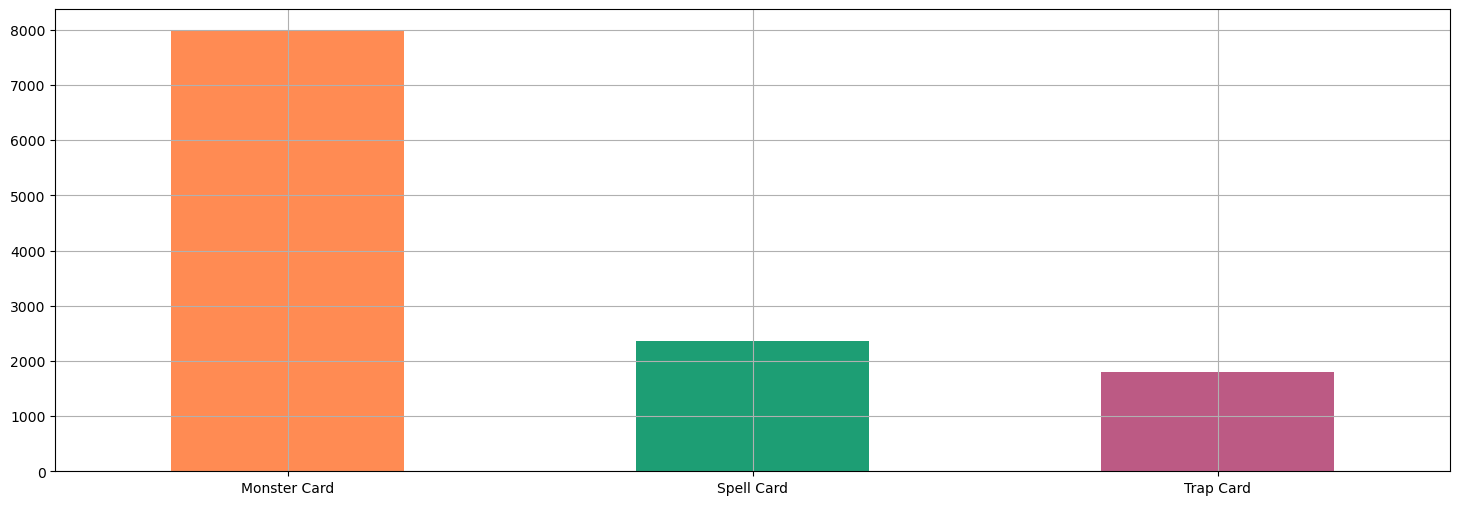

In [31]:
card_type_colors = [card_colors[i] for i in formatted_full_df['Card type'].value_counts().index]
formatted_full_df['Card type'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=0, color = card_type_colors)
plt.show()

## Monsters

### Attributes

In [ ]:
print('Total number of attributes:', formatted_monster_df['Attribute'].nunique())

In [ ]:
formatted_monster_df.drop(columns=['Card type']).groupby('Attribute').nunique()

In [ ]:
attribute_colors = [card_colors[i] for i in formatted_full_df['Attribute'].value_counts().index]
formatted_monster_df['Attribute'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=0, color = attribute_colors)
plt.show()

### Primary types

In [ ]:
print('Total number of primary types:', formatted_monster_df['Primary type'].nunique())

In [ ]:
formatted_monster_df.drop(columns=['Card type']).groupby('Primary type').nunique()

#### Has effect discrimination

In [ ]:
has_effect = formatted_monster_df['Primary type'].where(formatted_monster_df['Effect type'].notna()).value_counts().rename('Effect')
no_effect = formatted_monster_df['Primary type'].where(formatted_monster_df['Effect type'].isna()).value_counts().rename('No Effect')
effect = pd.concat([has_effect,no_effect], axis=1)
effect

In [ ]:
monster_type_colors = {'No Effect': card_colors['Normal Monster'], 'Effect': [card_colors[i] for i in effect.index]}
effect.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0,  legend=True, color = monster_type_colors)
plt.show()

Normal monster can have effect if it is pendulum

#### Is pendulum discrimination

In [ ]:
not_pendulum = formatted_monster_df['Primary type'].where(formatted_monster_df['Pendulum Scale'].isna()).value_counts().rename('Not Pendulum')
is_pendulum = formatted_monster_df['Primary type'].where(formatted_monster_df['Pendulum Scale'].notna()).value_counts().rename('Pendulum')
pendulum = pd.concat([not_pendulum,is_pendulum], axis=1)
pendulum

In [ ]:
monster_type_colors_b = {'Pendulum': card_colors['Pendulum Monster'], 'Not Pendulum': [card_colors[i] for i in pendulum.index]}
pendulum.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0, color = monster_type_colors_b, legend=True)
plt.show()

#### By attribute

In [ ]:
primmary_crosstab = pd.crosstab(formatted_full_df['Primary type'],formatted_full_df['Attribute'])
primmary_crosstab

In [ ]:
plt.figure(figsize = (16,10))
sns.heatmap(primmary_crosstab.T, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

### Secondary types

In [ ]:
print('Total number of secondary types:', formatted_monster_df['Secondary type'].nunique())

In [ ]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Secondary type').nunique()

In [ ]:
secondary_type_colors = card_colors['Effect Monster']
formatted_monster_df['Secondary type'].value_counts().plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0, color = secondary_type_colors, legend=True)
plt.show()

#### By attribute

In [ ]:
secondary_crosstab = pd.crosstab(formatted_full_df['Secondary type'],formatted_full_df['Attribute'])
secondary_crosstab

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(secondary_crosstab, annot=True, fmt="g", cmap='viridis', square=True)
plt.show()

#### By secondary type

In [ ]:
secondary_crosstab_b = pd.crosstab(formatted_full_df['Primary type'],formatted_full_df['Secondary type'], margins = True)
secondary_crosstab_b

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(secondary_crosstab_b, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

### Monster types

In [ ]:
print('Total number of monster types:', formatted_monster_df['Monster type'].nunique())

In [ ]:
formatted_monster_df.drop(columns=['Card type']).groupby('Monster type').nunique()

In [ ]:
monster_type_colors = card_colors['Monster Card']
formatted_monster_df['Monster type'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=45, color = monster_type_colors)
plt.show()

#### By Attribute

In [ ]:
monster_crosstab = pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Attribute'], dropna=False)
monster_crosstab

In [ ]:
plt.figure(figsize = (20,5))
sns.heatmap(monster_crosstab.T, annot=True, fmt="g", cmap='viridis', square=True)
plt.show()

#### By primary type

In [ ]:
monster_crosstab_b = pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Primary type'], dropna=False)
monster_crosstab_b

In [ ]:
plt.figure(figsize = (20,5))
sns.heatmap(monster_crosstab_b.T, annot=True, fmt="g", cmap='viridis', square=True, norm = LogNorm())
plt.show()

#### By secondary type

In [ ]:
monster_crosstab_c = pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Secondary type'], dropna=False)
monster_crosstab_c

In [ ]:
plt.figure(figsize = (20,5))
sns.heatmap(monster_crosstab_c.T, annot=True, fmt="g", cmap='viridis', square=True, norm = LogNorm())
plt.show()

### Effect type

In [ ]:
print('Total number of effect types:', formatted_monster_df['Effect type'].explode().nunique())

In [ ]:
formatted_monster_df[formatted_monster_df['Effect type'].notna()].drop(columns=['Card type']).explode('Effect type').groupby('Effect type').nunique()

In [ ]:
monster_effect_colors = card_colors['Effect Monster']
formatted_monster_df['Effect type'].explode('Effect type').value_counts().plot.bar(figsize = (18,6), grid = True, color = monster_effect_colors)
plt.show()

### ATK

In [ ]:
print('Total number of ATK values:', formatted_monster_df['ATK'].nunique())

In [ ]:
formatted_monster_df.drop(columns=['Card type']).groupby('ATK').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

In [ ]:
atk_colors = card_colors['Monster Card']
formatted_monster_df['DEF'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, color = atk_colors)
plt.show()

### DEF

In [ ]:
print('Total number of DEF values:', formatted_monster_df['DEF'].nunique())

In [ ]:
formatted_monster_df.drop(columns=['Card type']).groupby('DEF').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

In [ ]:
def_colors = card_colors['Monster Card']
formatted_monster_df['DEF'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, color = def_colors)
plt.show()

### Level/Rank

In [ ]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Level/Rank').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

In [ ]:
stars_colors = card_colors['Level']
formatted_monster_df['Level/Rank'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color= stars_colors)
plt.show()

#### ATK statistics

In [ ]:
formatted_monster_df[['Level/Rank','ATK']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Level/Rank').describe()

#### DEF statistics

In [ ]:
formatted_monster_df[['Level/Rank','DEF']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Level/Rank').describe()

### Pendulum scale

In [ ]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Pendulum Scale').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

In [ ]:
scales_colors = card_colors['Pendulum Monster']
formatted_monster_df['Pendulum Scale'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color = scales_colors)
plt.show()

#### ATK statistics

In [ ]:
formatted_monster_df[['Pendulum Scale','ATK']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Pendulum Scale').describe()

#### DEF statistics

In [ ]:
formatted_monster_df[['Pendulum Scale','DEF']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Pendulum Scale').describe()

#### Level/Rank statistics

In [ ]:
formatted_monster_df[['Pendulum Scale','Level/Rank']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Pendulum Scale').describe()

### Link

In [ ]:
formatted_monster_df.drop(columns=['Card type', 'Primary type', 'Secondary type','Level/Rank','DEF','Pendulum Scale']).groupby('Link').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

In [ ]:
link_colors = card_colors['Link Monster']
formatted_monster_df['Link'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color = link_colors)
plt.show()

#### ATK statistics

In [ ]:
formatted_monster_df[['Link','ATK']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Link').describe()

### Link Arrows

#### By combination

In [ ]:
print('Total number of link arrow combinations:', formatted_monster_df['Link Arrows'].nunique())

In [ ]:
formatted_monster_df.drop(columns=['Card type', 'Primary type', 'Level/Rank', 'Pendulum Scale', 'Link', 'Secondary type', 'DEF']).groupby('Link Arrows').nunique()

In [ ]:
arrows_colors = card_colors['Link Monster']
formatted_monster_df['Link Arrows'].value_counts().plot.bar(figsize = (18,6), logy=True, grid = True, color = arrows_colors)
plt.show()

#### By unique

In [ ]:
formatted_monster_df[formatted_monster_df['Link Arrows'].notna()].drop(columns=['Card type', 'Primary type', 'Level/Rank', 'Pendulum Scale', 'Secondary type', 'DEF']).explode('Link Arrows').groupby('Link Arrows').nunique()

In [ ]:
arrows_colors_b = card_colors['Link Monster']
formatted_monster_df['Link Arrows'].explode('Link Arrows').value_counts().plot.bar(figsize = (18,6), grid = True, color = arrows_colors_b)
plt.show()

#### By link

In [ ]:
arrow_per_link = formatted_monster_df[['Link Arrows','Link']].explode('Link Arrows').dropna()
arrow_crosstab = pd.crosstab(arrow_per_link['Link Arrows'],arrow_per_link['Link'])
arrow_crosstab

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(arrow_crosstab.T, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

## Spell & Trap

### Properties

In [ ]:
print('Total number of properties:', formatted_st_df['Property'].nunique())

In [ ]:
formatted_st_df.drop(columns=['Card type']).groupby('Property').nunique()

In [ ]:
st_colors = [card_colors[i] for i in formatted_full_df[['Card type','Property']].value_counts().index.get_level_values(0)]
formatted_st_df['Property'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=45, color = st_colors)
plt.show()

### Effect type

In [ ]:
print('Total number of effect types:', formatted_st_df['Effect type'].explode().nunique())

In [ ]:
formatted_st_df.explode('Effect type').groupby('Effect type').nunique()

#### Spell & Trap discrimination

In [ ]:
spell = formatted_spell_df['Effect type'].explode('Effect type').value_counts().rename('Spell Card')
trap = formatted_trap_df['Effect type'].explode('Effect type').value_counts().rename('Trap Card')
st_diff = pd.concat([spell, trap], axis = 1)
st_diff

In [ ]:
st_diff_colors = {'Spell Card': card_colors['Spell Card'], 'Trap Card': card_colors['Trap Card']}
st_diff.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=45, color = st_diff_colors)
plt.show()

## Archseries

In [ ]:
exploded_archseries = formatted_full_df.explode('Archseries')
print('Total number of Archseries:', exploded_archseries['Archseries'].nunique())

In [ ]:
exploded_archseries.groupby('Archseries').nunique()

In [ ]:
exploded_archseries['Archseries'].value_counts().plot.barh(figsize = (10,200), grid = True)
plt.show()

### By card type

In [ ]:
archseries_crosstab = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Card type'], margins = True)
archseries_crosstab

### By primary type

In [ ]:
archseries_crosstab_b = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Primary type'], margins = True)
archseries_crosstab_b



### By secondary type

In [ ]:
archseries_crosstab_c = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Secondary type'], margins = True)
archseries_crosstab_c

### By monster type

In [ ]:
archseries_crosstab_d = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Monster type'], margins = True)
archseries_crosstab_d

### By property

In [ ]:
archseries_crosstab_e = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Property'], margins = True)
archseries_crosstab_e

## Artworks

In [ ]:
print('Total number of cards with edited or alternate artworks:', formatted_full_df['Artwork'].count())

In [ ]:
formatted_full_df[['Name','Password','TCG status','OCG status','Artwork']][formatted_full_df['Artwork'].notna()]

In [ ]:
artwork_value_counts = formatted_full_df['Artwork'].value_counts()
plt.figure(figsize=(20,8))
venn2(subsets = (artwork_value_counts[('Alternate',)], artwork_value_counts[('Edited',)],artwork_value_counts[('Alternate','Edited')]), set_labels = ('Alternate artwork', 'Edited artwork'))
plt.show()

### By card type

In [ ]:
artwork_crosstab = pd.crosstab(formatted_full_df['Artwork'], formatted_full_df['Card type'])
artwork_crosstab

### By primary type

In [ ]:
artwork_crosstab_b = pd.crosstab(formatted_full_df['Artwork'], formatted_full_df['Primary type'])
artwork_crosstab_b

More granularity is unnecessary

## Errata

In [ ]:
print('Total number of cards with name or type errata:', formatted_full_df['Errata'].count())

In [ ]:
formatted_full_df[['Name','Password','TCG status','OCG status','Errata']][formatted_full_df['Errata'].notna()]

In [ ]:
errata_value_counts = formatted_full_df['Errata'].value_counts()
plt.figure(figsize=(20,8))
venn2(subsets = (errata_value_counts[('Name',)], errata_value_counts[('Type',)],errata_value_counts[('Name','Type')]), set_labels = ('Name Errata', 'Type errata'))
plt.show()

### By card type

In [ ]:
errata_crosstab = pd.crosstab(formatted_full_df['Errata'], formatted_full_df['Card type'])
errata_crosstab

### By primary type

In [ ]:
errata_crosstab_b = pd.crosstab(formatted_full_df['Errata'], formatted_full_df['Primary type'])
errata_crosstab_b

More granularity is unnecessary

### By artwork

In [ ]:
errata_crosstab_c = pd.crosstab(formatted_full_df['Artwork'], formatted_full_df['Errata'])
errata_crosstab_c

## TCG & OCG status

### TGC status

In [ ]:
print('Total number of TCG status:', formatted_full_df['TCG status'].nunique())

In [ ]:
formatted_full_df.groupby('TCG status', dropna=False).nunique()

In [ ]:
formatted_full_df['TCG status'].value_counts(dropna = False).plot.bar(figsize = (18,6), logy=True, grid = True, rot=45)
plt.show()

#### By card type

In [ ]:
# Remove unlimited
tcg_crosstab = pd.crosstab(formatted_full_df['Card type'], formatted_full_df['TCG status']).drop(['Unlimited'], axis=1)
tcg_crosstab

In [ ]:
plt.figure(figsize = (12,6))
sns.heatmap(tcg_crosstab, annot=True, fmt="g", cmap='viridis', norm=LogNorm())
plt.show()

#### By monster type

In [ ]:
# Remove unlimited
tcg_crosstab_b = pd.crosstab(formatted_full_df['Monster type'], formatted_full_df['TCG status']).drop(['Unlimited'], axis=1)
tcg_crosstab_b

In [ ]:
plt.figure(figsize = (20,5))
sns.heatmap(tcg_crosstab_b.T, annot=True, fmt="g", cmap='viridis', square = True, norm=LogNorm())
plt.show()

#### By archseries

In [ ]:
# Remove unlimited
tcg_crosstab_c = pd.crosstab(exploded_archseries['Archseries'].where(exploded_archseries['OCG status']!='Unlimited'), exploded_archseries['TCG status'], margins = True)
tcg_crosstab_c

### OCG status

In [ ]:
print('Total number of OCG status:', formatted_full_df['OCG status'].nunique())

In [ ]:
formatted_full_df.groupby('OCG status', dropna=False).nunique()

In [ ]:
formatted_full_df['OCG status'].value_counts(dropna = False).plot.bar(figsize = (18,6), logy=True, grid = True, rot=45)
plt.show()

#### By card type

In [ ]:
# Remove unlimited
ocg_crosstab = pd.crosstab(formatted_full_df['Card type'], formatted_full_df['OCG status']).drop(['Unlimited'], axis=1)
ocg_crosstab

In [ ]:
plt.figure(figsize = (12,6))
sns.heatmap(ocg_crosstab, annot=True, fmt="g", cmap='viridis', norm=LogNorm())
plt.show()

#### By monster type

In [ ]:
# Remove unlimited
ocg_crosstab_b = pd.crosstab(formatted_full_df['Monster type'], formatted_full_df['OCG status']).drop(['Unlimited'], axis=1)
ocg_crosstab_b

In [ ]:
plt.figure(figsize = (20,5))
sns.heatmap(ocg_crosstab_b.T, annot=True, fmt="g", cmap='viridis', square = True, norm=LogNorm())
plt.show()

#### By archseries

In [ ]:
# Remove unlimited
ocg_crosstab_c = pd.crosstab(exploded_archseries['Archseries'].where(exploded_archseries['OCG status']!='Unlimited'), exploded_archseries['OCG status'], margins = True)
ocg_crosstab_c

### TCG vs. OCG status

In [ ]:
cg_crosstab = pd.crosstab(formatted_full_df['OCG status'],formatted_full_df['TCG status'], dropna=False, margins = False)
cg_crosstab

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(cg_crosstab, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

# HTML export

In [ ]:
! jupyter nbconvert Cards.ipynb --to=HTML --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True

# Searches

In [ ]:
formatted_full_df.loc[formatted_full_df['OCG status'] == 'Not yet released'].loc[formatted_full_df['TCG status'] == 'Not yet released']

# Git

In [ ]:
! git add .

In [ ]:
! git commit -m {"Update-" + pd.Timestamp.now().strftime("%d%m%Y")}

In [ ]:
! git push